## Purpose
1. Replacing the behaviour of linear convolution filters with micro networks to improve the abstraction ability power of the CNN
2. To use a transformation that will link the final filter maps as confidence maps of the various categories 

## Motivation
Variants of visual concept generally lie on a non linear manifold. Linear convolutions act as a GLM and hence are unable to capture this invariance. Usual CNNs partially mitigate this issue by learning a overcomplete set of features capturing all possible variants. This makes the workload of succeeding layer more cumbersome as they have to combine all the information to learn invariance. This work proposes a solution to use MLP to act as non linear function approximators to learn invariant feature representations.
Global Average Pooling(GAP) of the final filter maps and directly feeding them to softmax layers creates a 1-1 correspondence between the filter map and category and hence they can be inferred as confidence map of said category. In addition GAP has no parameters and also makes the network more robust to spatial translation

## Methodology
MLP networks can be constructed as 3x3 followed by a bunch of 1x1 convolutional filters


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as tfunc
from torch.utils.data import dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
%matplotlib inline

In [3]:
mnist_X = torchvision.datasets.MNIST("./mnist",train=True,download=True,transform=torchvision.transforms.ToTensor())
mnist_length = mnist_X.__len__()
mnist_train,mnist_val = dataset.random_split(mnist_X,[int(0.9*mnist_length),mnist_length-int(0.9*mnist_length)])
mnist_test = torchvision.datasets.MNIST("./mnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

fmnist_X = torchvision.datasets.FashionMNIST("./fmnist",train=True,download=True,transform=torchvision.transforms.ToTensor())
fmnist_length = fmnist_X.__len__()
fmnist_train,fmnist_val = dataset.random_split(fmnist_X,[int(0.9*fmnist_length),fmnist_length-int(0.9*fmnist_length)])
fmnist_test = torchvision.datasets.FashionMNIST("./fmnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

emnist_X = torchvision.datasets.EMNIST("./emnist",split='balanced',train=True,download=True,transform=torchvision.transforms.ToTensor())
emnist_length = emnist_X.__len__()
emnist_train,emnist_val = dataset.random_split(emnist_X,[int(0.9*emnist_length),emnist_length-int(0.9*emnist_length)])
emnist_test = torchvision.datasets.EMNIST("./emnist",split='balanced',train=False,download=True,transform=torchvision.transforms.ToTensor())

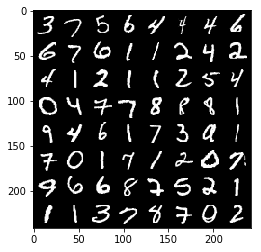

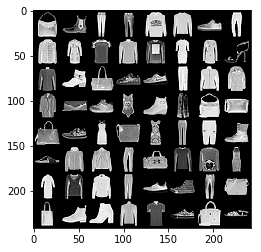

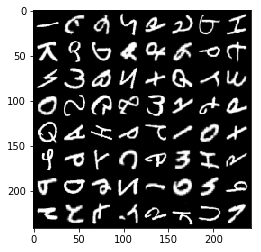

In [4]:
def imshow(dataset) :
    inp,_ = next(iter(torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)))
    inp = torchvision.utils.make_grid(inp)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
imshow(mnist_train)
imshow(fmnist_train)
imshow(emnist_train)

In [5]:
import torch.optim as optim
def train(net,lr,wd,dataset,loss_fn) :
    net.train()
    optimizer = optim.Adam(net.parameters(),lr=lr,weight_decay=wd)
    for x,y in dataset :
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_pred = net(x)
        loss_fn(y_pred,y).backward()
        optimizer.step()

def inference(net,dataset,loss_fn) :
    loss = 0
    with torch.no_grad() :
        net.eval()
        for x,y in dataset :
            x = x.cuda()
            y = y.cuda()
            y_pred = net(x)
            loss += loss_fn(y_pred,y).detach().cpu().numpy().item()
    return loss/dataset.dataset.__len__()

def run_epoch(net,lr,batch_size,train_dataset,val_dataset,test_dataset,train_loss,val_loss,max_epochs,wd=0) :
    train_losses = []
    val_losses = []
    test_losses = []
    train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=batch_size)
    
    for i in range(max_epochs+1) :
        train(net,lr,wd,train_loader,train_loss)
        if i%5 == 0:
            train_losses.append(inference(net,train_loader,val_loss))
            val_losses.append(inference(net,val_loader,val_loss))
            test_losses.append(inference(net,test_loader,val_loss))
            print("epoch : {},train_loss : {:.2f},val_loss : {:.2f},test_loss : {:.2f}".format(i,train_losses[-1],val_losses[-1],test_losses[-1]))
    return train_losses,val_losses,test_losses
       

In [6]:
class MLPConv(nn.Sequential) :
    def __init__(self,channels,ksize,drop_rate,in_channels=None) :
        super(MLPConv,self).__init__() 
        in_channels = in_channels if in_channels else channels
        self.add_module("linear_conv",nn.Conv2d(in_channels,channels,ksize,padding=ksize//2))
        self.add_module("activation_0",nn.ReLU(inplace=True))
        self.add_module("dropout_0",nn.Dropout2d(p=drop_rate))
        self.add_module("hidden",nn.Conv2d(channels,channels,1))
        self.add_module("activation_1",nn.ReLU(inplace=True))
        self.add_module("dropout_1",nn.Dropout2d(p=drop_rate))
        self.add_module("output",nn.Conv2d(channels,channels,1))
        self.add_module("activation_2",nn.ReLU(inplace=True))
        self.add_module("dropout_2",nn.Dropout2d(p=drop_rate))
        
class NINet(nn.Module) :
    def __init__(self,init_channels=1,init_filters=192,depth=3,num_classes=10,drop_rate=0.2) :
        super(NINet,self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth) :
            if i == 0 :
                layer = nn.Sequential(MLPConv(init_filters,3,drop_rate,init_channels),nn.MaxPool2d(2,2))
            elif i < depth-1 :
                layer = nn.Sequential(MLPConv(init_filters,3,drop_rate),nn.MaxPool2d(2,2))
            else :
                layer = MLPConv(init_filters,3,drop_rate)
            self.layers.append(layer)
        self.classifier = nn.Sequential(nn.Conv2d(init_filters,num_classes,1),nn.ReLU())
        
    def forward(self,x,debug=False) :
        debug_outs = []        
        for layer in self.layers :
            x = layer(x)
            debug_outs.append(x)
        x = self.classifier(x)
        debug_outs.append(x)
        x = x.view(x.shape[0],x.shape[1],-1).mean(dim=2)
        debug_outs.append(x)
        return x if not debug else debug_outs

In [7]:
def zero_one_loss(y_pred,y_true) :
    indices = torch.argmax(y_pred,dim=1,keepdim=True).type_as(y_true)
    y_true = y_true.view(-1,1)
    return torch.sum(torch.eq(indices-y_true,0))

epoch : 0,train_loss : 0.51,val_loss : 0.51,test_loss : 0.51
epoch : 5,train_loss : 0.95,val_loss : 0.95,test_loss : 0.95
epoch : 10,train_loss : 0.97,val_loss : 0.97,test_loss : 0.98
epoch : 15,train_loss : 0.98,val_loss : 0.98,test_loss : 0.98
epoch : 20,train_loss : 0.98,val_loss : 0.98,test_loss : 0.99
epoch : 25,train_loss : 0.99,val_loss : 0.98,test_loss : 0.99
epoch : 30,train_loss : 0.99,val_loss : 0.99,test_loss : 0.99
epoch : 35,train_loss : 0.99,val_loss : 0.99,test_loss : 0.99
epoch : 40,train_loss : 0.99,val_loss : 0.99,test_loss : 0.99
epoch : 45,train_loss : 0.99,val_loss : 0.99,test_loss : 0.99
epoch : 50,train_loss : 0.99,val_loss : 0.99,test_loss : 0.99


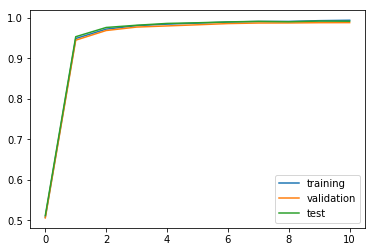

In [8]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
mnist_net = NINet().cuda()
train_loss = nn.CrossEntropyLoss()
val_loss = zero_one_loss
mtr,mv,mte = run_epoch(mnist_net,1e-4,128,mnist_train,mnist_val,mnist_test,train_loss,val_loss,50,0)
plt.plot(mtr)
plt.plot(mv)
plt.plot(mte)
plt.legend(['training','validation','test'],loc='lower right')
plt.show()
torch.save(mnist_net.state_dict(),'mnist_net_nin.mod')

epoch : 0,train_loss : 0.75,val_loss : 0.76,test_loss : 0.74
epoch : 5,train_loss : 0.85,val_loss : 0.86,test_loss : 0.84
epoch : 10,train_loss : 0.89,val_loss : 0.88,test_loss : 0.88
epoch : 15,train_loss : 0.91,val_loss : 0.90,test_loss : 0.90
epoch : 20,train_loss : 0.92,val_loss : 0.91,test_loss : 0.90
epoch : 25,train_loss : 0.92,val_loss : 0.91,test_loss : 0.91
epoch : 30,train_loss : 0.93,val_loss : 0.91,test_loss : 0.91
epoch : 35,train_loss : 0.94,val_loss : 0.92,test_loss : 0.92
epoch : 40,train_loss : 0.94,val_loss : 0.92,test_loss : 0.91
epoch : 45,train_loss : 0.94,val_loss : 0.92,test_loss : 0.92
epoch : 50,train_loss : 0.95,val_loss : 0.93,test_loss : 0.92


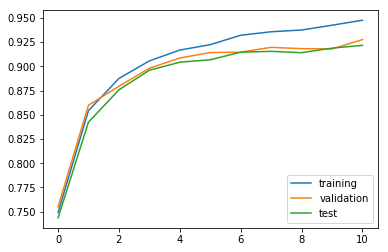

In [9]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
fmnist_net = NINet().cuda()
train_loss = nn.CrossEntropyLoss()
val_loss = zero_one_loss
ftr,fv,fte = run_epoch(fmnist_net,1e-3,128,fmnist_train,fmnist_val,fmnist_test,train_loss,val_loss,50,0)
plt.plot(ftr)
plt.plot(fv)
plt.plot(fte)
plt.legend(['training','validation','test'],loc='lower right')
plt.show()
torch.save(fmnist_net.state_dict(),'fmnist_net_nin.mod')

epoch : 0,train_loss : 0.24,val_loss : 0.24,test_loss : 0.24
epoch : 5,train_loss : 0.78,val_loss : 0.77,test_loss : 0.78
epoch : 10,train_loss : 0.85,val_loss : 0.84,test_loss : 0.84
epoch : 15,train_loss : 0.87,val_loss : 0.86,test_loss : 0.86
epoch : 20,train_loss : 0.88,val_loss : 0.87,test_loss : 0.87
epoch : 25,train_loss : 0.88,val_loss : 0.88,test_loss : 0.87
epoch : 30,train_loss : 0.89,val_loss : 0.88,test_loss : 0.88
epoch : 35,train_loss : 0.89,val_loss : 0.88,test_loss : 0.88
epoch : 40,train_loss : 0.89,val_loss : 0.88,test_loss : 0.88
epoch : 45,train_loss : 0.89,val_loss : 0.88,test_loss : 0.88
epoch : 50,train_loss : 0.90,val_loss : 0.89,test_loss : 0.89
epoch : 55,train_loss : 0.90,val_loss : 0.89,test_loss : 0.89
epoch : 60,train_loss : 0.90,val_loss : 0.89,test_loss : 0.89
epoch : 65,train_loss : 0.90,val_loss : 0.89,test_loss : 0.89
epoch : 70,train_loss : 0.90,val_loss : 0.89,test_loss : 0.89
epoch : 75,train_loss : 0.90,val_loss : 0.89,test_loss : 0.89


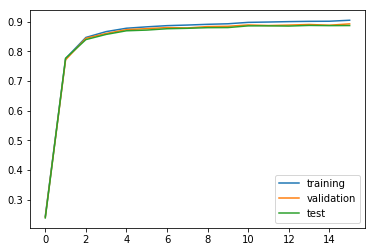

In [10]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
emnist_net = NINet(num_classes=47).cuda()
train_loss = nn.CrossEntropyLoss()
val_loss = zero_one_loss
etr,ev,ete = run_epoch(emnist_net,1e-4,64
                       ,emnist_train,emnist_val,emnist_test,train_loss,val_loss,75,0.0)
plt.plot(etr)
plt.plot(ev)
plt.plot(ete)
plt.legend(['training','validation','test'],loc='lower right')
plt.show()
torch.save(emnist_net.state_dict(),'emnist_net_nin.mod')

In [21]:
def imshow_features(net,dataset,num_iters) :
    net.eval()
    for i in range(num_iters) :
        print("\n\n\n\nDisplaying Input")
        inp,_ = next(iter(torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)))
        inpu = inp.squeeze().numpy()
        plt.imshow(inpu,cmap='gray')
        plt.show()
        debug_outs = net(inp.cuda(),debug=True)
        print("Displaying Activations")
        for out in debug_outs[0:-1] :
            out = torch.transpose(out.cpu().detach(),0,1)
            inp = torchvision.utils.make_grid(out,nrow=16)
            plt.imshow(inp.permute(1, 2,0))
            plt.show()






Displaying Input


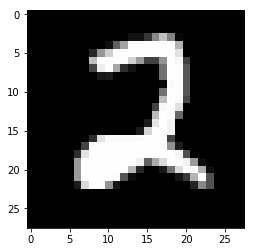

Displaying Activations


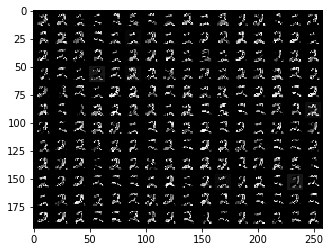

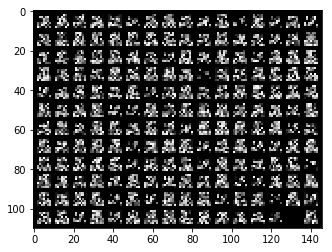

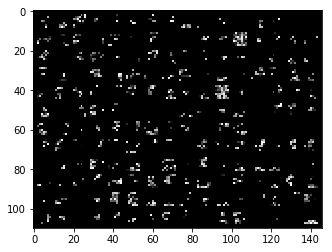

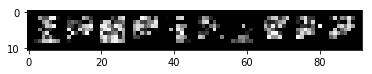





Displaying Input


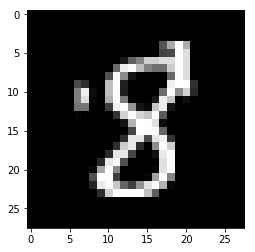

Displaying Activations


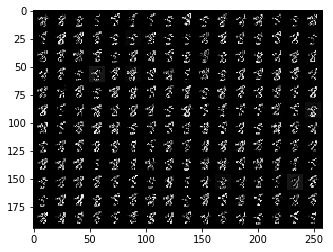

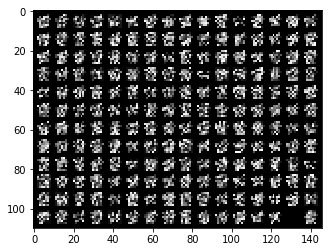

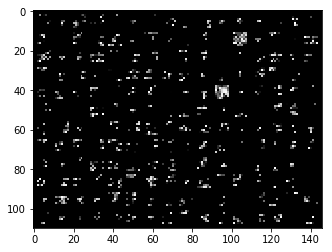

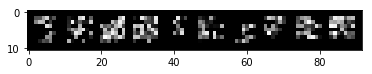





Displaying Input


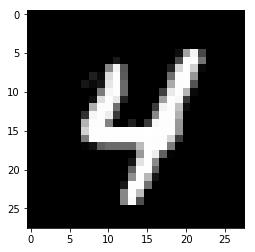

Displaying Activations


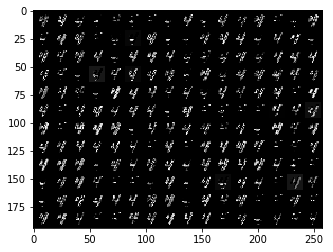

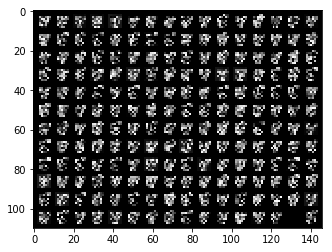

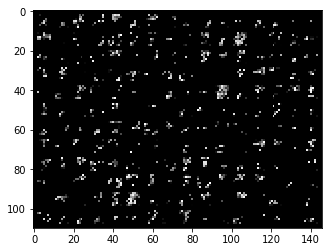

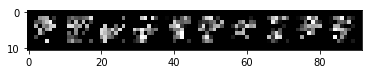





Displaying Input


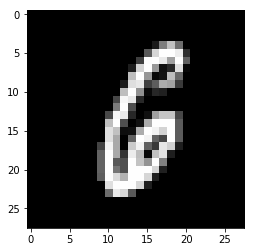

Displaying Activations


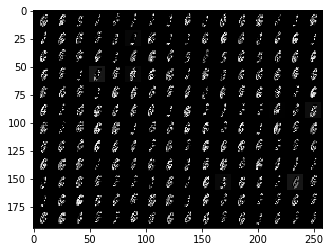

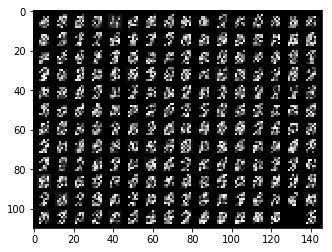

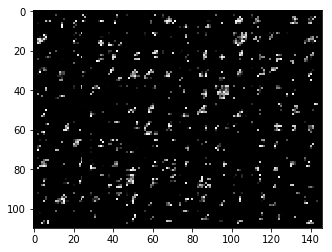

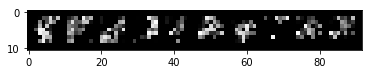





Displaying Input


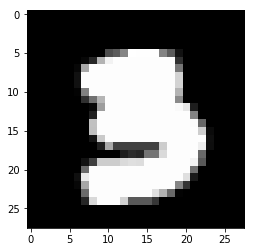

Displaying Activations


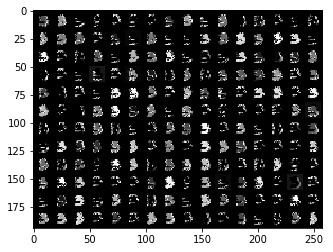

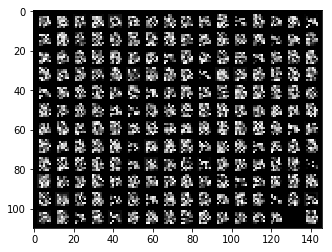

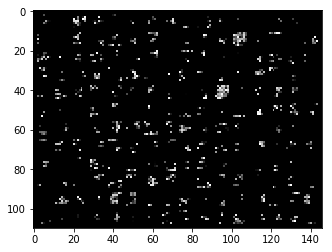

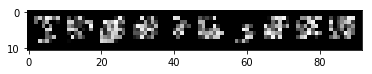

In [22]:
imshow_features(mnist_net,mnist_test,5)





Displaying Input


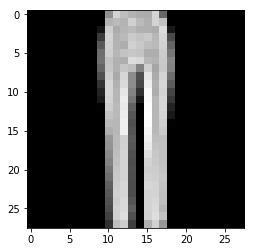

Displaying Activations


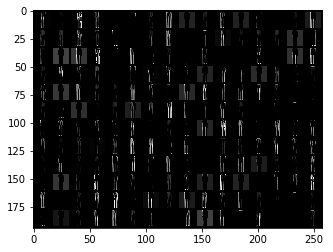

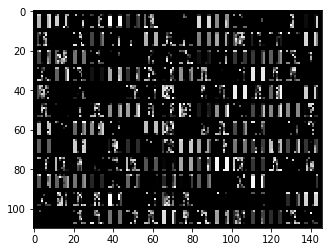

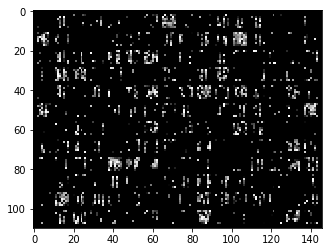

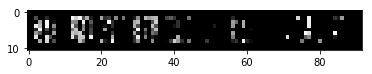





Displaying Input


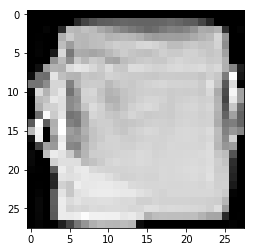

Displaying Activations


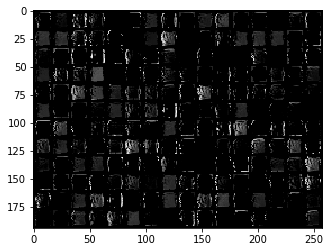

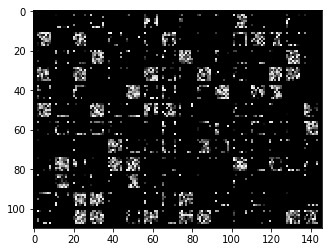

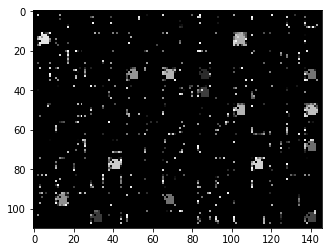

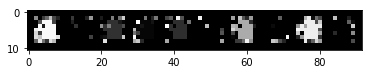





Displaying Input


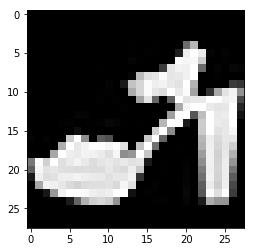

Displaying Activations


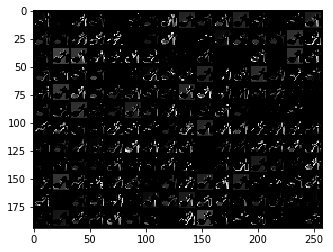

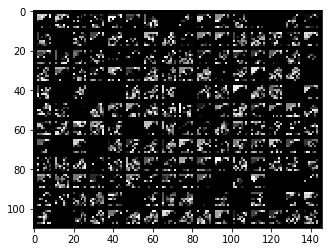

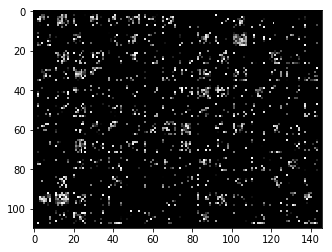

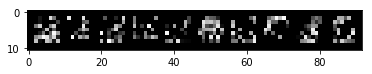





Displaying Input


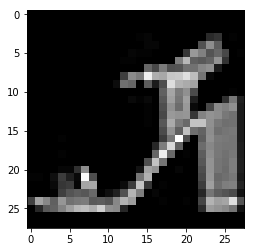

Displaying Activations


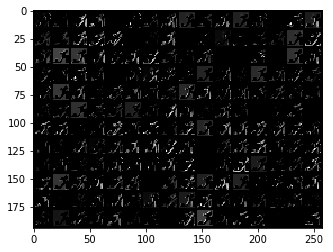

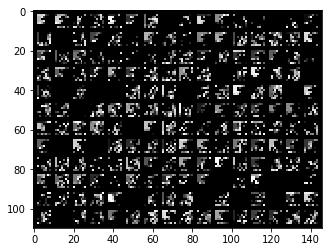

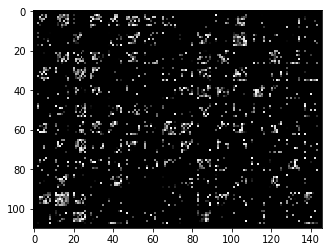

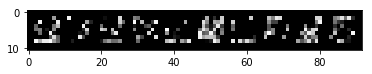





Displaying Input


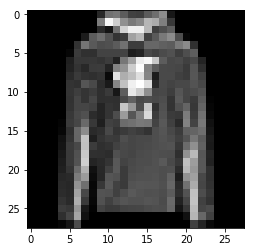

Displaying Activations


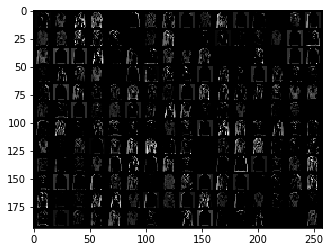

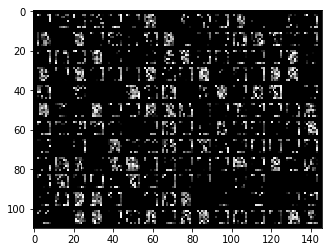

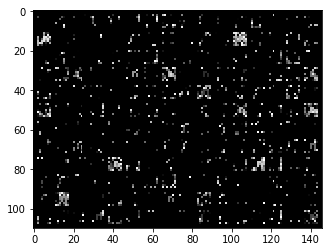

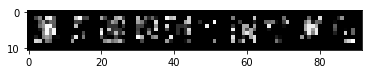

In [25]:
imshow_features(fmnist_net,fmnist_test,5)





Displaying Input


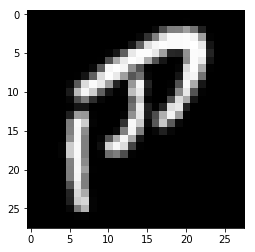

Displaying Activations


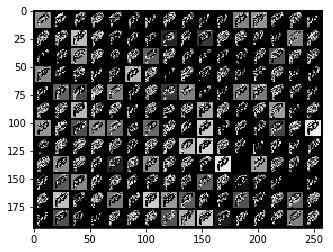

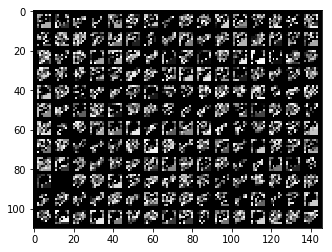

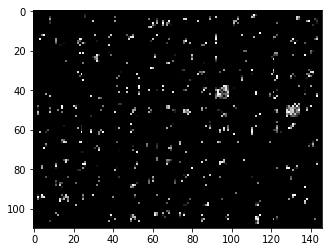

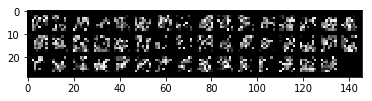





Displaying Input


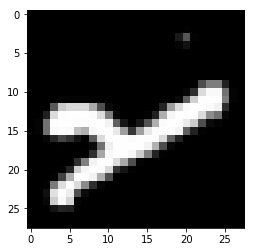

Displaying Activations


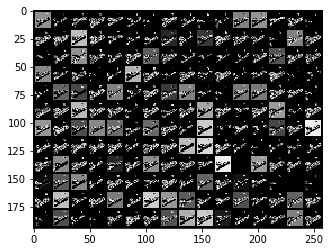

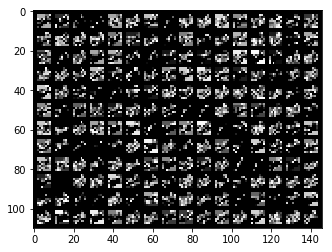

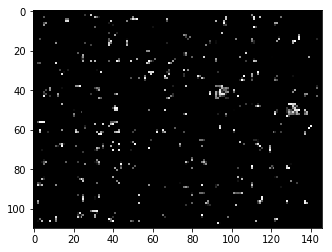

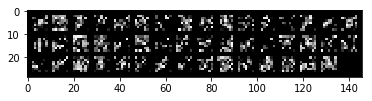





Displaying Input


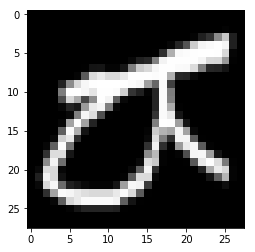

Displaying Activations


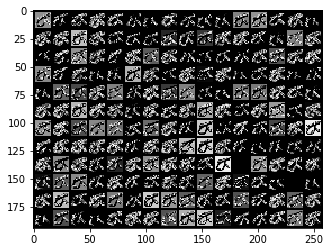

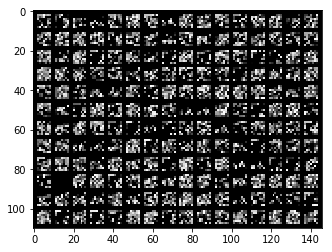

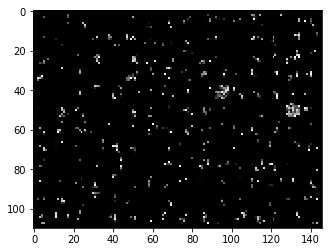

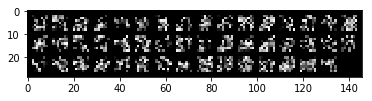





Displaying Input


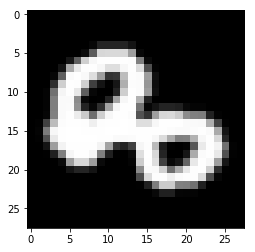

Displaying Activations


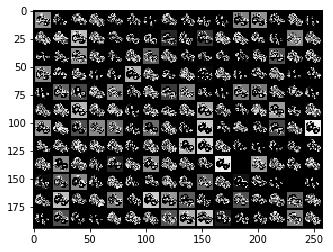

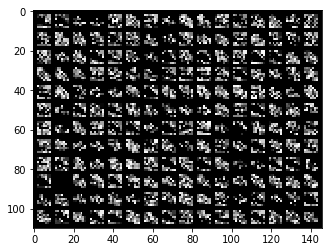

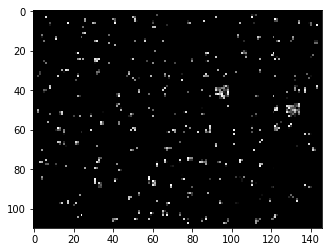

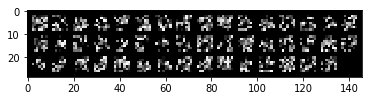





Displaying Input


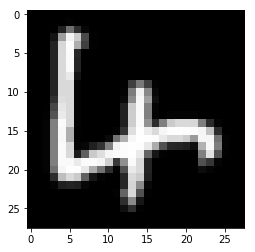

Displaying Activations


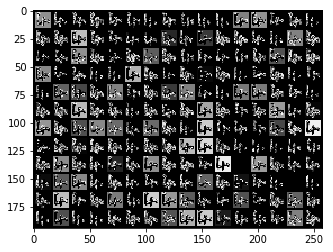

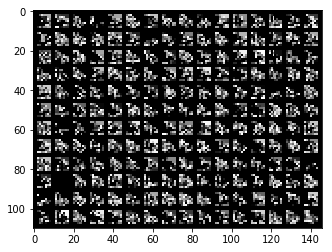

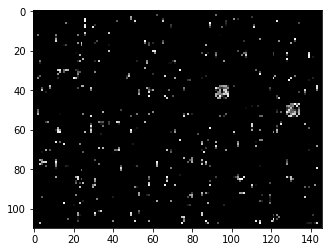

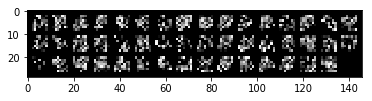

In [26]:
imshow_features(emnist_net,emnist_test,5)

### Results and Discussion
In mnist dataset the network achieves nearly perfect accuracy. For the FMnist and EMnist dataset the network achieves approximately 93% and 90% respectively.
During the course of training the above models, I noticed that the network was very sensitive to the number of channels and was easily prone to reach a local optima. I believe that the network was reaching a local optima because no matter the number of iterations the network was unable to improve its results. It also needed the dropout to be part of the MLPConv module for it to achieve a decent training accuracy.

### References
[Network in Network paper](https://arxiv.org/abs/1312.4400)

[MNist](http://yann.lecun.com/exdb/mnist/)

[FMnist](https://github.com/zalandoresearch/fashion-mnist)

[EMnist](https://www.westernsydney.edu.au/bens/home/reproducible_research/emnist)